# pyPSFstack use example

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from pyPSFstack.pupils.sources import DipoleInterfaceSource
from pyPSFstack.pupils.windows import SEO
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
from pyPSFstack.diversities.pola_diversities import PDiversity_QWP, \
    PDiversity_LP, PDiversity_Compound
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring import ExactBlurring

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import pyPSFstack

In [3]:
pyPSFstack.blurring.NoBlurring()

# Modelling a PSF stack with a SEO Fourier window followed by a QWP and Wollaston prism 

## 1. Setting the source and Fourier window

Let us begin by specifying the experimental parameters:

In [2]:
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
radius = 100
distance_coverslip = radius/2
wavelength = 525

These parameters, in turn, fix the pupil properties:

In [3]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = 256

Then we define the pupil sequence that we want to model. In general this will be composed by a source and a window at the Fourier plane. 

In [4]:
params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = distance_coverslip/wavelength

params['window'] = {}
params['window']['c'] = np.pi#1.24*np.pi

In [6]:
src = DipoleInterfaceSource(**params['pupil'],**params['source'])
wdw = SEO(**params['pupil'],**params['window'])
pupil_sequence = [src, wdw]

We can plot the source and window

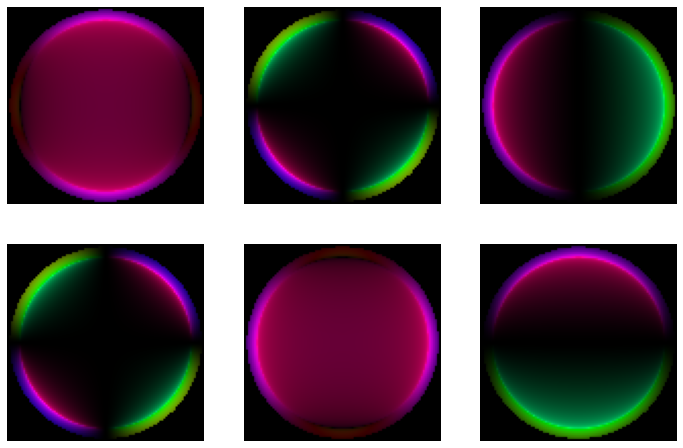

In [7]:
src.plot_pupil_field()

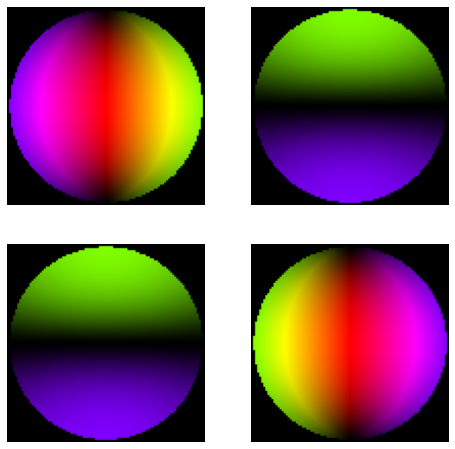

In [8]:
wdw.plot_pupil_field()

## 2. Defining the pupil and polarization diversities, and the blurring

Then we define the phase and polarization diversities:

In [9]:
params['zdiversity'] = {}
zi = -300; zf = 300; z_step = 100
params['zdiversity']['z_list'] = np.arange(zi,zf+z_step,z_step) / wavelength
params['zdiversity']['nf'] = nf
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])

The polarization splitting can be modelled by a polarization diversity

In [10]:
qwp = PDiversity_QWP([np.pi/4])
wollaston = PDiversity_LP([0, np.pi/2])
pdiv = PDiversity_Compound([qwp, wollaston])

The type of blurring is defined by a `Bluring` class which determines the needed diversities at the pupil lane and the blurring kernel

In [15]:
params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,8)[1:-1] 
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

## 3. Computing the PSF stack

Finally, we initialize an instance of the class `PSFStack` which allows us to compute the desired PSF stack and even model the effect of background, photobleaching and noise:

In [13]:
psfs = PSFStack(pupil_sequence, zdiversity=zdiv, pdiversity=pdiv)
psfs.compute_psf_stack(orientation=[0,0,0])

In [16]:
psfs_blurred = PSFStack(pupil_sequence, zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs_blurred.compute_psf_stack(orientation=[0,0,0])

Let us visualize the result:

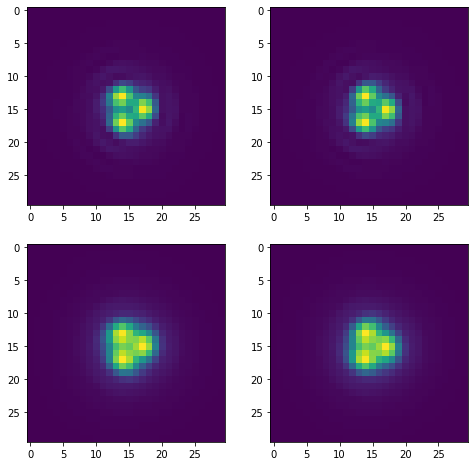

In [19]:
zdiv_mid_ind = int((zf-zi)/z_step//2)
stack = trim_stack(psfs.psf_stack, 30)
blurred_stack = trim_stack(np.abs(psfs_blurred.psf_stack), 30)
fig, ax = plt.subplots(2,2,figsize=(8,8))
for ind in range(2):
    ax[0,ind].imshow(stack[...,zdiv_mid_ind-1,ind])
    ax[1,ind].imshow(blurred_stack[...,zdiv_mid_ind-1,ind])

Now, we can model the effect of background illumination and noise. This is defined in terms of the maximum number of photons at a given pixel for the whole stack:

In [12]:
modelled_stack = psfs.model_experimental_stack(bckgd_photons=30,N_photons=100,N_pts=30)

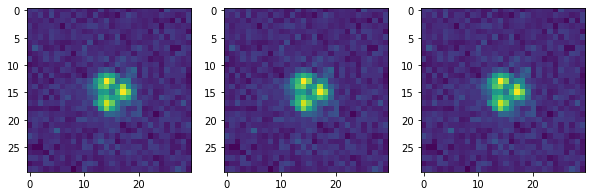

In [13]:
pdiv_ind = 0
zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, ax = plt.subplots(1,3,figsize=(10,10))
for ind in range(3):
    ax[ind].imshow(modelled_stack[...,zdiv_mid_ind-1,pdiv_ind])

# Tests